In [77]:
from __future__ import division

import os, sys
from ctypes import *
import math
import random
import glob
import tqdm
import numpy as np
import cv2
from matplotlib import image as mat_image, patches, pyplot as plt
import multiprocessing as mp
from PIL import Image

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet'))

from sample import Sample

class YOLODetector(object):
    # Attributes
    __path = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet')
    __cfg = None
    __model = None
    __dat = None
    __net, __meta = None, None
    
    # Initializer
    def __init__(self):
        __path = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet')
#         self.__cfg_path = bytes(os.path.join(__path,"cfg", cfg), 'utf-8')
#         self.__model_path = bytes(os.path.join(__path,"backup", model), 'utf-8')
#         self.__dat_path = bytes(os.path.join(__path,"cfg", dat), 'utf-8')
    
        class BOX(Structure):
            _fields_ = [("x", c_float),
                            ("y", c_float),
                            ("w", c_float),
                            ("h", c_float)]

        class DETECTION(Structure):
            _fields_ = [("bbox", BOX),
                            ("classes", c_int),
                            ("prob", POINTER(c_float)),
                            ("mask", POINTER(c_float)),
                            ("objectness", c_float),
                            ("sort_class", c_int)]

        class IMAGE(Structure):
            _fields_ = [("w", c_int),
                            ("h", c_int),
                            ("c", c_int),
                            ("data", POINTER(c_float))]

        class METADATA(Structure):
            _fields_ = [("classes", c_int),
                        ("names", POINTER(c_char_p))]

         # SETUP
        lib = CDLL(os.path.join(__path,"libdarknet.so"), RTLD_GLOBAL)
        lib.network_width.argtypes = [c_void_p]
        lib.network_width.restype = c_int
        lib.network_height.argtypes = [c_void_p]
        lib.network_height.restype = c_int
        self.lib = lib
        
        predict = self.lib.network_predict
        predict.argtypes = [c_void_p, POINTER(c_float)]
        predict.restype = POINTER(c_float)
        self.predict = predict

        set_gpu = self.lib.cuda_set_device
        set_gpu.argtypes = [c_int]
        self.set_gpu = set_gpu
        
        make_image = self.lib.make_image
        make_image.argtypes = [c_int, c_int, c_int]
        make_image.restype = IMAGE
        self.make_image = make_image
        
        get_network_boxes = self.lib.get_network_boxes
        get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int)]
        get_network_boxes.restype = POINTER(DETECTION)
        self.get_network_boxes = get_network_boxes
        
        
        make_network_boxes = self.lib.make_network_boxes
        make_network_boxes.argtypes = [c_void_p]
        make_network_boxes.restype = POINTER(DETECTION)
        self.make_network_boxes = make_network_boxes
        
        free_detections = self.lib.free_detections
        free_detections.argtypes = [POINTER(DETECTION), c_int]
        self.free_detections = free_detections
        
        free_ptrs = self.lib.free_ptrs
        free_ptrs.argtypes = [POINTER(c_void_p), c_int]
        self.free_ptrs = free_ptrs
        
        network_predict = self.lib.network_predict
        network_predict.argtypes = [c_void_p, POINTER(c_float)]
        self.network_predict = network_predict
        
        reset_rnn = self.lib.reset_rnn
        reset_rnn.argtypes = [c_void_p]
        self.reset_rnn = reset_rnn
        
        load_net = self.lib.load_network
        load_net.argtypes = [c_char_p, c_char_p, c_int]
        load_net.restype = c_void_p
        self.load_net = load_net
    
        do_nms_obj = self.lib.do_nms_obj
        do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]
        self.do_nms_obj = do_nms_obj
        
        do_nms_sort = self.lib.do_nms_sort
        do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]
        self.do_nms_sort = do_nms_sort

        free_image = self.lib.free_image
        free_image.argtypes = [IMAGE]
        self.free_image = free_image

        letterbox_image = self.lib.letterbox_image
        letterbox_image.argtypes = [IMAGE, c_int, c_int]
        letterbox_image.restype = IMAGE
        self.letterbox_image = letterbox_image
        
        load_meta = self.lib.get_metadata
        self.lib.get_metadata.argtypes = [c_char_p]
        self.lib.get_metadata.restype = METADATA
        self.load_meta = load_meta

        load_image = self.lib.load_image_color
        load_image.argtypes = [c_char_p, c_int, c_int]
        load_image.restype = IMAGE
        self.load_image = load_image

        rgbgr_image = self.lib.rgbgr_image
        rgbgr_image.argtypes = [IMAGE]
        self.rgbgr_image = rgbgr_image
        
        predict_image = self.lib.network_predict_image
        predict_image.argtypes = [c_void_p, IMAGE]
        predict_image.restype = POINTER(c_float)
        self.predict_image = predict_image
        
    def sample(probs):
        s = sum(probs)
        probs = [a/s for a in probs]
        r = random.uniform(0, 1)
        for i in range(len(probs)):
            r = r - probs[i]
            if r <= 0:
                return i
        return len(probs)-1

    def c_array(ctype, values):
        arr = (ctype*len(values))()
        arr[:] = values
        return arr
    
    def classify(net, meta, im):
        out = self.predict_image(net, im)
        res = []
        for i in range(meta.classes):
            res.append((meta.names[i], out[i]))
        res = sorted(res, key=lambda x: -x[1])
        return res

    def load_model(self, data_file, model_weights):
        self.__cfg = bytes(os.path.join(self.__path,'models', 'cfg','model.cfg'), 'utf-8')
        self.__model = bytes(os.path.join(self.__path,'models', model_weights), 'utf-8')
        self.__dat = bytes(os.path.join(self.__path,'models','cfg',data_file), 'utf-8')
#         print(self.__cfg, self.__model, self.__dat)
        self.__net = self.load_net(self.__cfg, self.__model, 0)
        self.__meta = self.load_meta(self.__dat)
    
    def detect(self, image, thresh=.5, hier_thresh=.5, nms=.45):
        """Apply YOLO to the image"""
        net = self.__net
        meta = self.__meta
        im = self.load_image(image, 0, 0)
        num = c_int(0)
        pnum = pointer(num)
        self.predict_image(net, im)
        dets = self.get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum)
        num = pnum[0]
        if (nms): self.do_nms_obj(dets, num, meta.classes, nms);
        res = []
        for j in range(num):
            for i in range(meta.classes):
                if dets[j].prob[i] > 0:
                    b = dets[j].bbox
                    res.append((meta.names[i], dets[j].prob[i], (b.x, b.y, b.w, b.h)))
        res = sorted(res, key=lambda x: -x[1])
        self.free_image(im)
        self.free_detections(dets, num)
        return res
    
    def yolo_labelled_img(self, img, thresh=.5, y_size=3):
        """Plot the data and the corresponding label and boxes"""
        bboxes = self.detect(bytes(img,'utf-8'), thresh=thresh)
        im_data = mat_image.imread(img)
        im_data = cv2.imread(img)[:,:,::-1]
        fig, ax = plt.subplots(1, figsize=(y_size*(im_data.shape[1]/im_data.shape[0]),y_size))
        ax.imshow(im_data)
        for bbox in bboxes:
            color = 'cornflowerblue' if bbox[0]==b'Whistler' else 'lightcoral'
            event = bbox[0].decode("utf-8") 
            prob = bbox[1]
            x,y,w,h = bbox[2][0], bbox[2][1], bbox[2][2], bbox[2][3] 
            t_size, f_size, _ = im_data.shape
            x1 = int((x-w/2))
            x2 = int((x+w/2))
            y1 = int((y-h/2))
            y2 = int((y+h/2))
#             print(im_data.shape, x,y,w,h,x1,x2,y1,y2)
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.text(x1,y1,str(event)+' p='+str(round(prob,3)), fontsize=12, bbox={'facecolor':color, 'pad':2, 'ec':color})
            ax.add_patch(rect)
        plt.show()
    


model = "real"
model_weights=model+".weights"
data_file = model+'.data'
yolo = YOLODetector()
yolo.load_model(data_file, model_weights)
files = []
f = open("/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/test.txt", "r")
# f = open("/home/othniel/wdml/data/datasets/simulations/yolo/test.txt", "r")
for line in f:
    files.append(line.split(os.linesep)[0])
    
    

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT11:59:34.58649609.marion.jpg
[(b'Whistler', 0.8489323854446411, (726.673583984375, 96.8336410522461, 144.161376953125, 52.94045639038086)), (b'Whistler', 0.6149255633354187, (78.31993865966797, 97.75469970703125, 133.79293823242188, 58.956390380859375)), (b'Whistler', 0.490083783864975, (910.6036376953125, 98.41535949707031, 136.13731384277344, 59.60353469848633)), (b'Whistler', 0.21775022149085999, (749.58154296875, 83.28057861328125, 252.21226501464844, 69.27236938476562))]


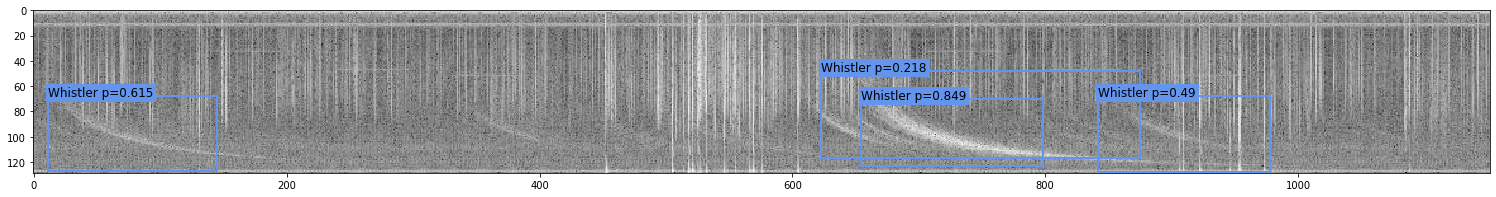

In [75]:
thresh = 0.2
file = random.choice(files)
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-02-22UT03:52:58.39267602.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-26UT01:34:59.92291914.marion.jpg'
# file = /home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-06UT17:14:19.14211922.marion.jpg
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-02UT14:45:55.61571914.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-10-20UT23:06:03.34899422.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT13:56:51.00131922.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT16:37:57.91971914.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT15:52:36.07607109.marion.jpg'
# file = '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg'
r = yolo.detect(bytes(file,'utf-8'), thresh=thresh)
print(file)
print(r)
yolo.yolo_labelled_img(file, thresh=thresh)

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-02-22UT03:52:58.39267602.marion.jpg
[(b'Whistler', 0.9796460866928101, (415.0728759765625, 91.306396484375, 155.13739013671875, 57.040367126464844))]


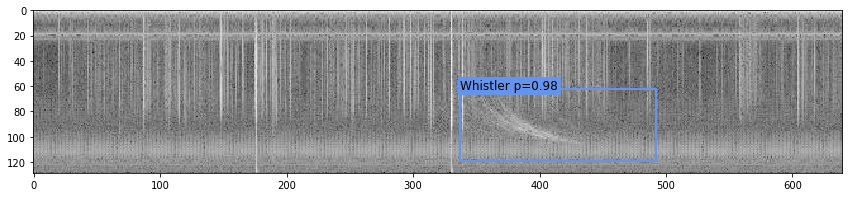

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-26UT01:34:59.92291914.marion.jpg
[(b'Whistler', 0.8555231094360352, (333.0823974609375, 95.79376983642578, 152.25978088378906, 63.95728302001953)), (b'Whistler', 0.7011944055557251, (426.28759765625, 94.01724243164062, 150.88294982910156, 57.936588287353516))]


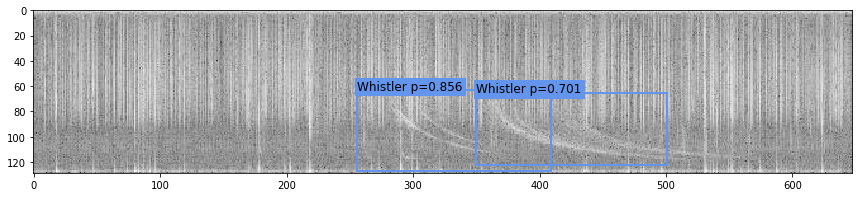

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-06UT17:14:19.14211922.marion.jpg
[(b'Whistler', 0.878553032875061, (481.1374206542969, 94.20140838623047, 177.46888732910156, 58.37308120727539)), (b'Whistler', 0.43689289689064026, (245.60340881347656, 95.44918060302734, 171.3338165283203, 58.73466110229492))]


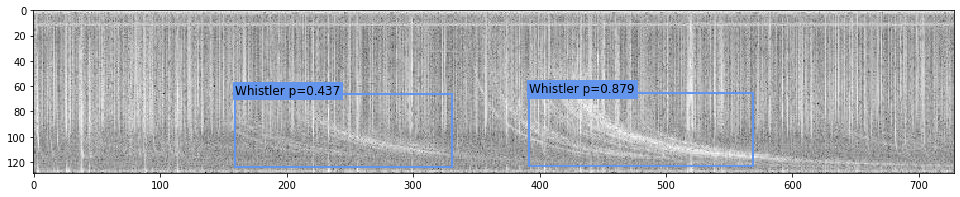

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-10UT14:49:27.68611938.marion.jpg
[(b'Whistler', 0.9393311142921448, (408.7199401855469, 92.19310760498047, 146.27098083496094, 58.00457763671875))]


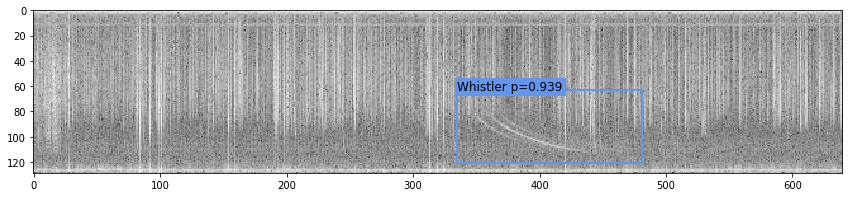

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-02UT16:37:44.14691914.marion.jpg
[(b'Whistler', 0.44295206665992737, (425.7742614746094, 93.87127685546875, 123.82481384277344, 58.265750885009766)), (b'Whistler', 0.3441585302352905, (286.3954772949219, 94.20686340332031, 107.6244888305664, 59.21047592163086))]


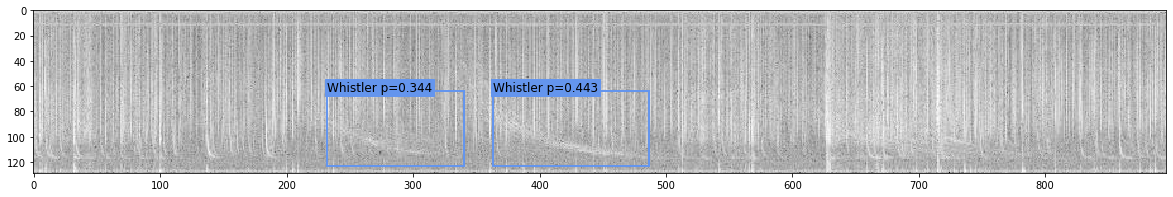

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg
[(b'Whistler', 0.4665805697441101, (590.2406005859375, 91.08370971679688, 130.98219299316406, 53.591346740722656)), (b'Whistler', 0.38197091221809387, (479.30023193359375, 92.6827163696289, 183.61549377441406, 63.6644172668457))]


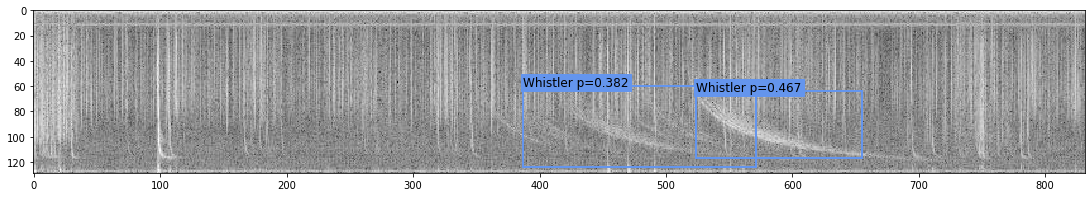

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-02UT14:45:55.61571914.marion.jpg
[(b'Whistler', 0.9398621320724487, (406.2453308105469, 94.2166976928711, 148.09092712402344, 59.933349609375))]


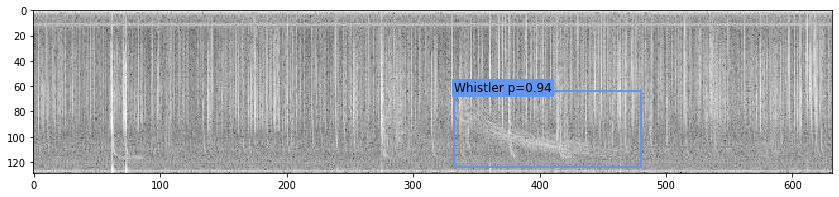

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-10-20UT23:06:03.34899422.marion.jpg
[(b'Whistler', 0.7649737596511841, (333.0018615722656, 104.74443054199219, 169.41104125976562, 58.424781799316406)), (b'Whistler', 0.41905444860458374, (444.7209777832031, 103.43994903564453, 180.5921173095703, 59.48402404785156))]


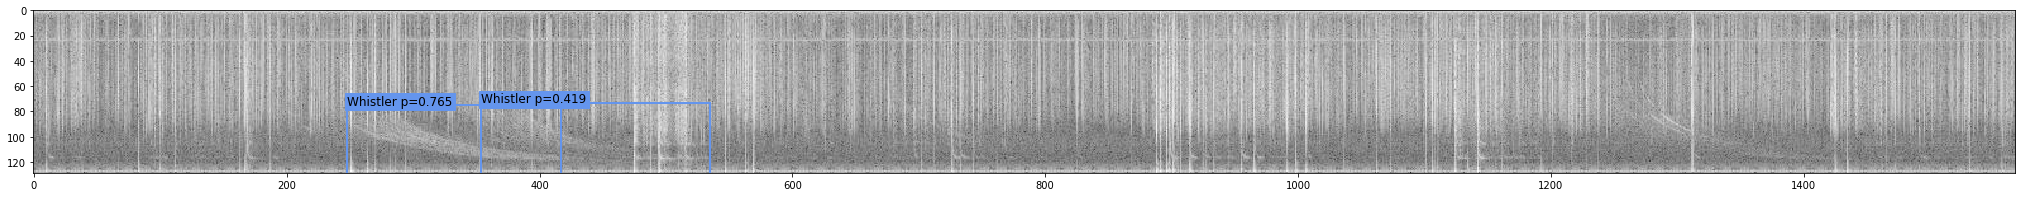

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT13:56:51.00131922.marion.jpg
[(b'Whistler', 0.5918729901313782, (403.37530517578125, 92.00922393798828, 140.77284240722656, 55.833404541015625)), (b'Whistler', 0.5866416096687317, (749.224365234375, 91.87564849853516, 140.18878173828125, 57.43199920654297))]


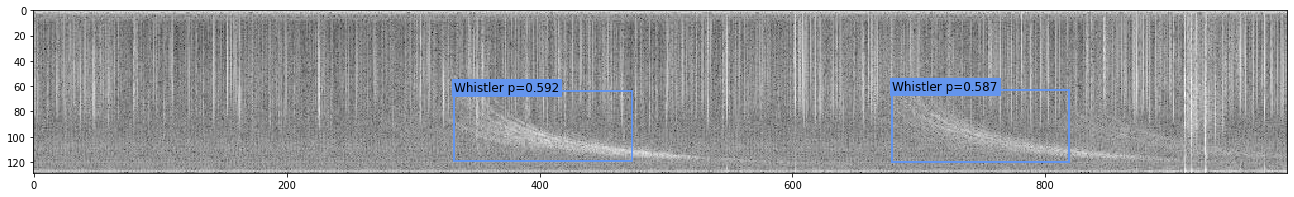

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-28UT22:24:57.32451922.marion.jpg
[(b'Whistler', 0.942671537399292, (427.7569274902344, 91.44100952148438, 163.0078125, 58.60906982421875))]


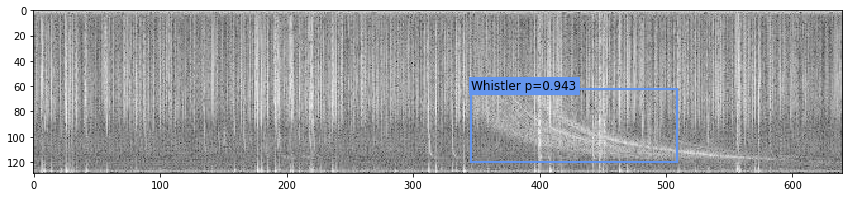

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT16:37:57.91971914.marion.jpg
[(b'Whistler', 0.8938429355621338, (423.88531494140625, 94.0576171875, 150.87754821777344, 61.80523681640625))]


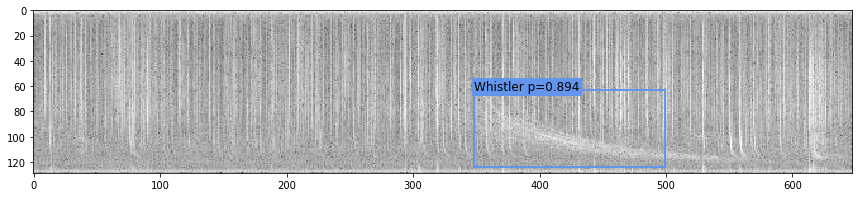

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT15:52:36.07607109.marion.jpg
[(b'Whistler', 0.7616595029830933, (486.84161376953125, 95.23930358886719, 236.86178588867188, 68.66966247558594)), (b'Whistler', 0.33497729897499084, (405.51226806640625, 94.83502960205078, 140.97291564941406, 56.171058654785156)), (b'Whistler', 0.23403587937355042, (138.2408447265625, 92.58492279052734, 122.91783142089844, 59.46432113647461))]


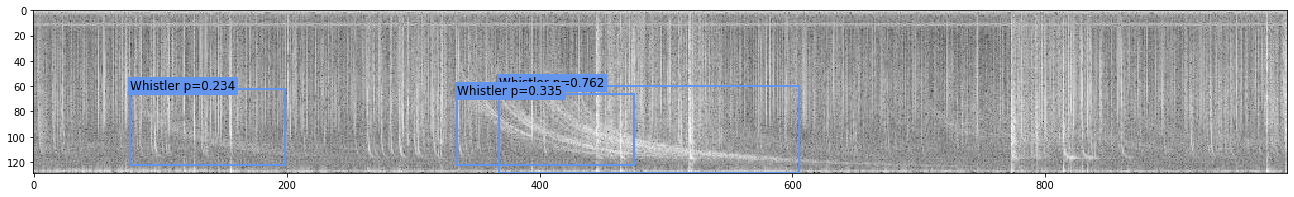

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT11:59:34.58649609.marion.jpg
[(b'Whistler', 0.8489323854446411, (726.673583984375, 96.8336410522461, 144.161376953125, 52.94045639038086)), (b'Whistler', 0.6149255633354187, (78.31993865966797, 97.75469970703125, 133.79293823242188, 58.956390380859375)), (b'Whistler', 0.490083783864975, (910.6036376953125, 98.41535949707031, 136.13731384277344, 59.60353469848633)), (b'Whistler', 0.21775022149085999, (749.58154296875, 83.28057861328125, 252.21226501464844, 69.27236938476562))]


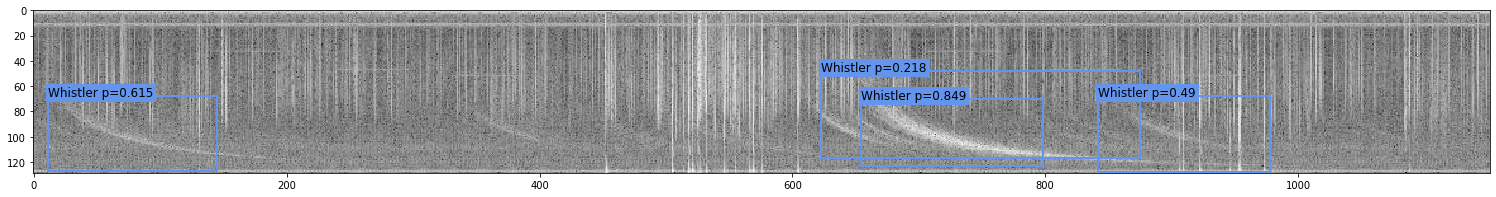

/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg
[(b'Whistler', 0.4665805697441101, (590.2406005859375, 91.08370971679688, 130.98219299316406, 53.591346740722656)), (b'Whistler', 0.38197091221809387, (479.30023193359375, 92.6827163696289, 183.61549377441406, 63.6644172668457))]


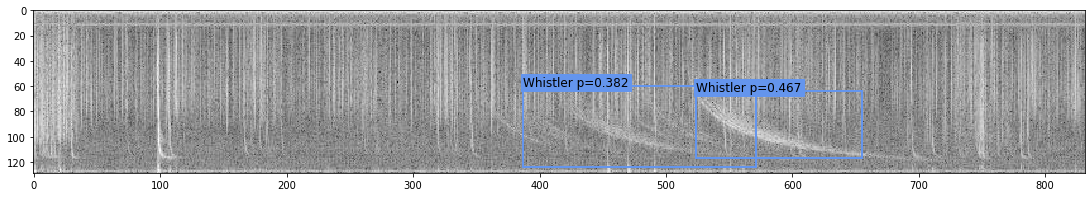

In [78]:
thresh = 0.2
file = random.choice(files)
files = ['/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-02-22UT03:52:58.39267602.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-26UT01:34:59.92291914.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-06UT17:14:19.14211922.marion.jpg',
         '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-10UT14:49:27.68611938.marion.jpg',
         '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-02UT16:37:44.14691914.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-02UT14:45:55.61571914.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-10-20UT23:06:03.34899422.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT13:56:51.00131922.marion.jpg',
         '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-28UT22:24:57.32451922.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-29UT16:37:57.91971914.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT15:52:36.07607109.marion.jpg',
         '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-06-09UT11:59:34.58649609.marion.jpg',
        '/home/othniel/wdml/data/databases/awdEvents1/marion/yolo/data/2013-07-07UT14:48:34.02851914.marion.jpg']
for file in files:
    r = yolo.detect(bytes(file,'utf-8'), thresh=thresh)
    print(file)
    print(r)
    yolo.yolo_labelled_img(file, thresh=thresh)